In [1]:
import matplotlib.pyplot as plt
import numpy as np

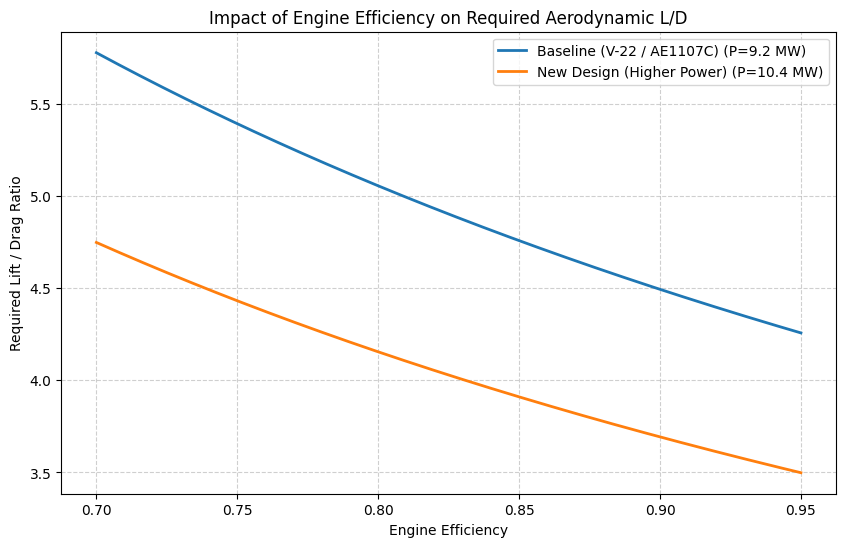

In [2]:
### Level flight, cruise: OPTIMISING FOR L/D ###
def LD_cruise(m_fuel, m_aircraft, m_payload, V, P):
    m = m_fuel + m_aircraft + m_payload
    lift = m * 9.81 # equals weight
    drag = P / V # equals thrust

    return lift/drag
    
def LD_plot(configs, eff_range):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for name, data in configs.items():
        m_fuel = data['fuel']
        m_ac = data['aircraft']
        m_pay = data['payload']
        V = data['speed']
        P = data['power']
        
        base_LD = LD_cruise(m_fuel, m_ac, m_pay, V, P)
        
        actual_LD = base_LD / eff_range
        
        # Plot
        ax.plot(eff_range, actual_LD, linewidth=2, label=f"{name} (P={P/1e6:.1f} MW)")

    ax.set_xlabel("Engine Efficiency")
    ax.set_ylabel("Required Lift / Drag Ratio")
    ax.set_title("Impact of Engine Efficiency on Required Aerodynamic L/D")
    ax.grid(True, which='both', linestyle='--', alpha=0.6)
    ax.legend(loc='best')
    
    plt.show()

def Vmax_cruise(density, wing_loading, K, Cd0):
    return np.sqrt((2/density) * wing_loading * np.sqrt(K/Cd0))

# cruise test
# parameters based on existing V-22
# these are test parameters to show the existing engine as a baseline

efficiency_factor = np.linspace(0.7, 0.95, 1000) # assumption, no data as of yet
engine_configs = {
    "Baseline (V-22 / AE1107C)": {
        "payload": 9050.0,
        "fuel": 6100.0,
        "aircraft": 27400.0 - 9050.0 - 6100.0, # derived structure mass
        "speed": 138.0, # m/s
        "power": 2*4586000.0 # 2*4.58 MW Engines, based on RR AE1107C 
    },
    "New Design (Higher Power)": { # INITIAL ASSUMPTION, TO TWEAK LATER
        "payload": 6000.0, # Same payload
        "fuel": 5800.0,    # Maybe new engine is lighter/more efficient?
        "aircraft": 12500.0, 
        "speed": 145.0,    # Target higher cruise?
        "power": 2*5200000.0 # 5.2 MW
    }
}

air_density = np.linspace(0.493, 1.225, 1000) 

LD_plot(engine_configs, efficiency_factor)

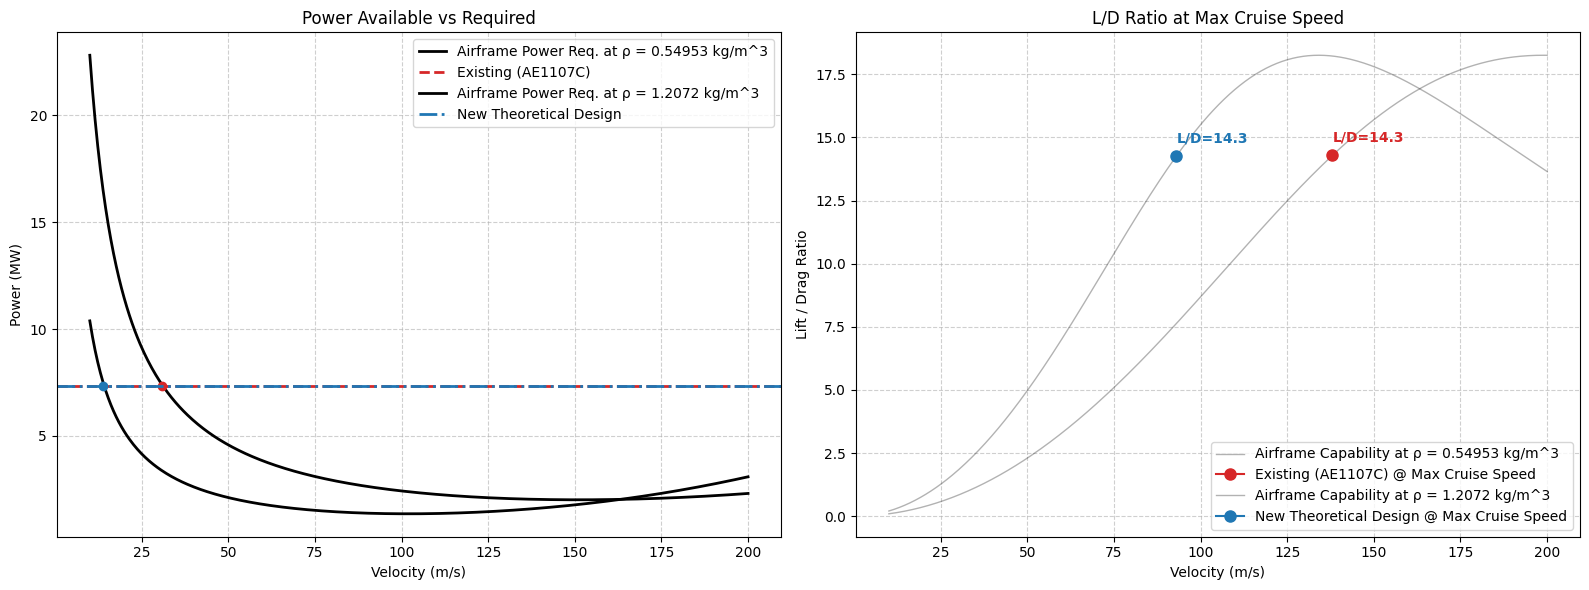

In [3]:
def get_power_required(v_range, density, weight, S, Cd0, K):
    q = 0.5 * density * v_range**2
    Cl = weight / (q * S)
    Cd = Cd0 + (K * Cl**2)
    Drag = q * S * Cd
    P_req = Drag * v_range
    
    return P_req, Drag

def compare_engines_performance(aircraft, engines, v_range):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    W = aircraft['weight']
    S = aircraft['wing_area']
    Cd0 = aircraft['Cd0']
    K = aircraft['K'] 

    colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple']
    styles = ['--', '-.', ':', '--']

    for i, (name, specs) in enumerate(engines.items()):

        density = specs['rho']
        
        P_req, Drag_req = get_power_required(v_range, density, W, S, Cd0, K)
        LD_ratio_curve = W / Drag_req
    
        ax1.plot(v_range, P_req/1e6, color='black', linewidth=2, label=f'Airframe Power Req. at ρ = {density} kg/m^3')
    
        ax2.plot(v_range, LD_ratio_curve, color='black', alpha=0.3, linewidth=1, label=f'Airframe Capability at ρ = {density} kg/m^3')
        
        P_shaft = specs['power']
        eff = specs['efficiency']
        P_avail = P_shaft * eff 
        c = colors[i % len(colors)]
        s = styles[i % len(styles)]
        
        ax1.axhline(y=P_avail/1e6, color=c, linestyle=s, linewidth=2, label=f'{name}')
        
        idx = np.argwhere(np.diff(np.sign(P_avail - P_req))).flatten()
        if idx.size > 0:
            p_max = v_range[idx[0]]
            #note: this essentailly identifies the speed and L/D at takeoff i.e. the point at which the power can make the aircraft airborne
            v_max = specs['cruise_speed']
            
            ax1.plot(p_max, P_avail/1e6, marker='o', color=c)
            q = 0.5 * density * v_max**2
            Cl = W / (q * S)
            Cd = Cd0 + (K * Cl**2)
            Drag_at_max = q * S * Cd
            LD_at_max = W / Drag_at_max
            
            ax2.plot(v_max, LD_at_max, marker='o', markersize=8, color=c, label=f'{name} @ Max Cruise Speed')
            
            ax2.annotate(f'L/D={LD_at_max:.1f}', 
                        (v_max, LD_at_max), 
                        xytext=(0, 10), textcoords='offset points', 
                        color=c, fontweight='bold')

    ax1.set_xlabel("Velocity (m/s)")
    ax1.set_ylabel("Power (MW)")
    ax1.set_title("Power Available vs Required")
    ax1.legend(loc='best')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    ax2.set_xlabel("Velocity (m/s)")
    ax2.set_ylabel("Lift / Drag Ratio")
    ax2.set_title("L/D Ratio at Max Cruise Speed")
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

#rho = 
rho = 1.2072 #kg/m^3, assuming cruise at 500ft
v_sweep = np.linspace(10, 200, 500) 

## CD0, AND K ARE ASSUMPTIONS 
aircraft_config = {
    'weight': 21500 * 9.81, # kg -> N
    'wing_area': 35.49,      # m^2
    'Cd0': 0.015,           # Zero-lift drag coefficient (Clean config)
    'K': 0.05               # Induced drag factor
}

engine_configs = {
    "Existing (AE1107C)": {
        'power': 2*4.586e6,
        'efficiency': 0.80,
        'cruise_speed': 138, #m/s
        'rho': 0.54953 # kg/m^3, assuming cruise at 25000ft
    },
    "New Theoretical Design": {
        'power': 2*4.586e6, # same for now
        'efficiency': 0.80, # same for now
        'cruise_speed': 93, #m/s - the speed at which searches are carried out
        'rho': 1.2072 # kg/m^3, assuming cruise at 500ft
    }
}

compare_engines_performance(aircraft_config, engine_configs, v_sweep)

In [75]:
### Vertical Takeoff ###
# max thrust should allow one engine to hover the aircraft such that V_y = 0
def max_thrust(mass, acc, g): # total thrust 
    return mass * g

# def takeoff_kinematics(acceleration, target_height):
#     V = np.sqrt(2 * acceleration * target_height)
#     time = V / acceleration

#     fig, ax1 = plt.subplots()
#     ax1.plot(acceleration, time)
#     ax1.set_xlabel('Vertical Acceleration (m/s^2)')
#     ax1.set_ylabel("time (s)")
#     ax1.set_title(f"Time to get to h={target_height} m")
#     plt.show()

def propeller_sizing(T_Max, density, V_e, delta_pressure): # assuming in test bed or during single engine hover
    T_prop_gross = T_Max * 0.95 # assuming 95% of thrust comes from the prop
    Area = 2 * T_prop_gross / (delta_pressure - density * V_e ** 2)
    return np.sqrt(4 * Area / np.pi)

def prop_max_power(T_Max, density, prop_eff, dp):
    return np.sqrt((2 * (T_Max ** 3)) / (np.pi * density)) / (prop_eff * dp)
    
max_weight = 12000 + 6000 + 2000 #kg
gravity = 9.81 #m/s^2
downwards_acc = 0.5
acc = np.linspace(0.1, 5, 500)
height = 1500 #m, roughly 5k ft
air_density = 1.05 #  np.linspace(1.05, 1.225, 100) # range between sea level to 1500 m

# takeoff_kinematics(acc, height)
thrust_maximum = max_thrust(max_weight, downwards_acc, gravity)
prop_diameter = propeller_sizing(thrust_maximum, air_density, 30, 15000)
P = prop_max_power(thrust_maximum, air_density, 0.90, 11.6)

print(f"T_max = {thrust_maximum}, D_p = {prop_diameter}, P = {P}")

T_max = 196200.0, D_p = 5.811201523249633, P = 6481767.036585483


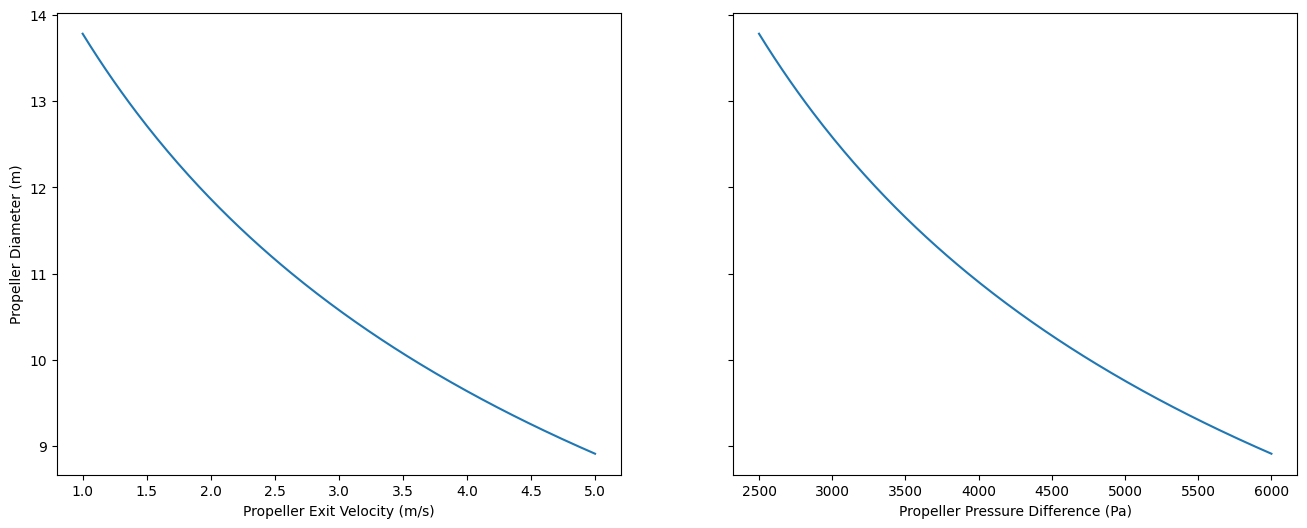

In [86]:
dp_range = np.linspace(2500, 6000, 200)
ve_range = np.linspace(1, 5, 200)

variable_prop = propeller_sizing(thrust_maximum, air_density, ve_range, dp_range)

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(16, 6), sharey='all')
ax1.plot(ve_range, variable_prop)
ax2.plot(dp_range, variable_prop)
ax1.set_ylabel("Propeller Diameter (m)")
ax1.set_xlabel("Propeller Exit Velocity (m/s)")
ax2.set_xlabel("Propeller Pressure Difference (Pa)")
plt.show()

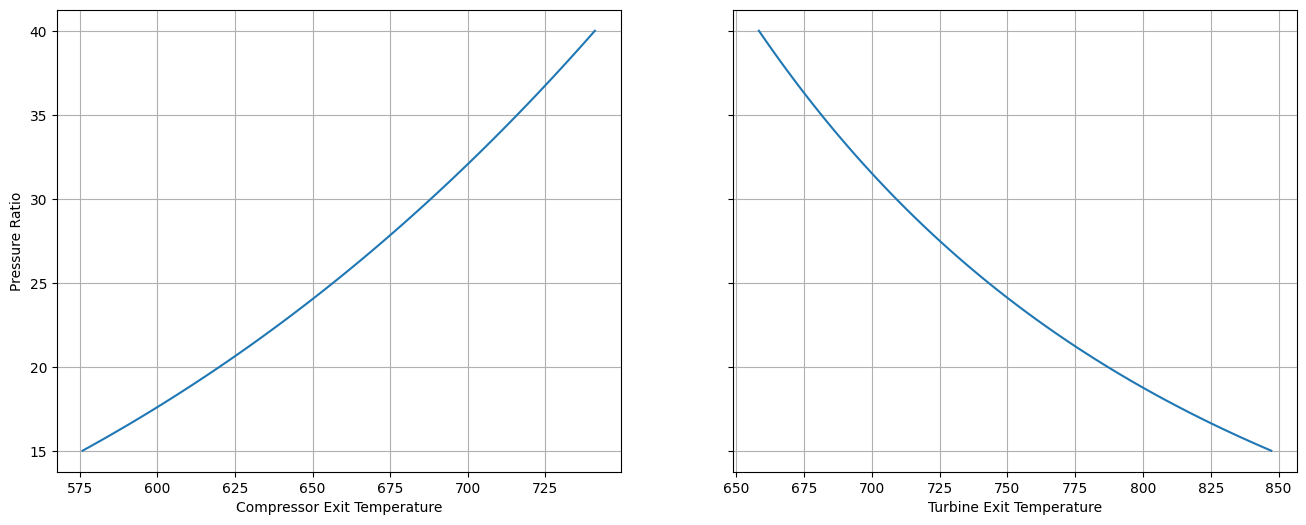

In [109]:
def temp_ratio(p, gamma):
    return p ** (0.9 * (gamma - 1) / gamma)

T4 = 1700 #K
T2 = 287
P2 = 101325 #kPa
specific_heat_ratio = 1.4
pressure_ratio_range = np.linspace(15,40,100)
temp_ratio_range = temp_ratio(pressure_ratio_range, specific_heat_ratio)

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(16, 6), sharey='all')
ax1.plot(T2 * temp_ratio_range, pressure_ratio_range)
ax1.set_xlabel("Compressor Exit Temperature")
ax1.set_ylabel("Pressure Ratio")
ax1.grid()
ax2.plot(T4 / temp_ratio_range, pressure_ratio_range)
ax2.set_xlabel("Turbine Exit Temperature")
ax2.grid()

In [3]:
### Horizontal Takeoff ###

In [ ]:
### Search ###
# high air density, low V

In [ ]:
### Hover ###
# high  air density, V = 0